Max Flow
Iteration 1 augmenting path
[987654321, 7, 6, 1234567890]


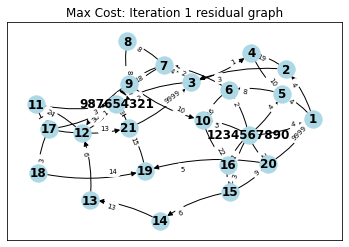

Iteration 2 augmenting path
[987654321, 3, 2, 1, 1234567890]


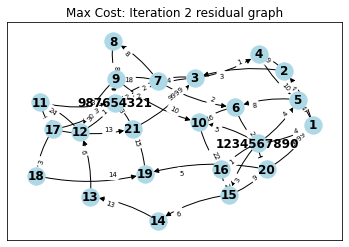

Iteration 3 augmenting path
[987654321, 21, 19, 20, 1234567890]


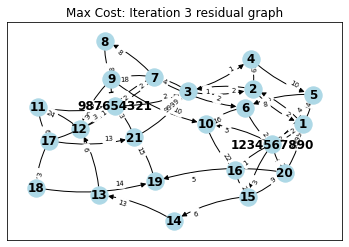

Iteration 4 augmenting path
[987654321, 7, 3, 2, 1, 1234567890]


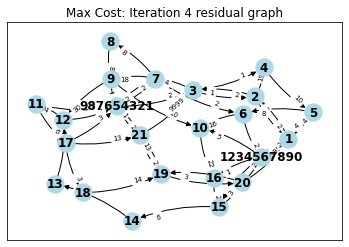

Iteration 5 augmenting path
[987654321, 12, 13, 14, 15, 1234567890]


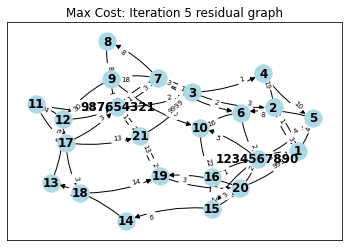

Iteration 6 augmenting path
[987654321, 21, 19, 20, 15, 1234567890]


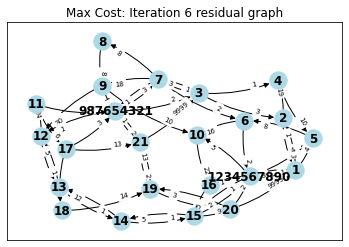

Iteration 7 augmenting path
[987654321, 11, 12, 13, 14, 15, 1234567890]


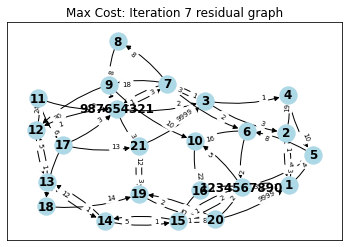

Iteration 8 augmenting path
[987654321, 11, 12, 13, 14, 15, 16, 1234567890]


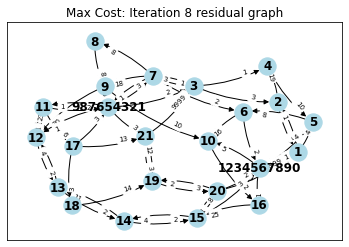

Iteration 9 augmenting path
[987654321, 11, 12, 13, 14, 15, 16, 10, 1234567890]


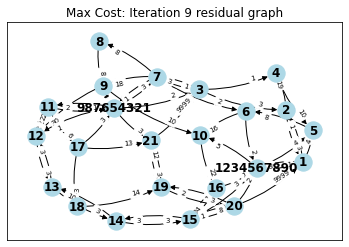

Iteration 10 augmenting path
[987654321, 7, 3, 21, 19, 20, 15, 16, 10, 1234567890]


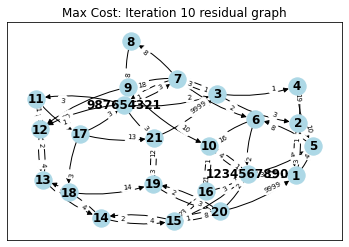

Iteration 11 augmenting path
[987654321, 17, 11, 12, 13, 14, 15, 16, 10, 1234567890]


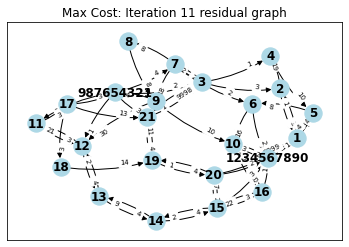

Iteration 12 augmenting path
[987654321, 9, 7, 3, 21, 19, 20, 15, 16, 10, 1234567890]


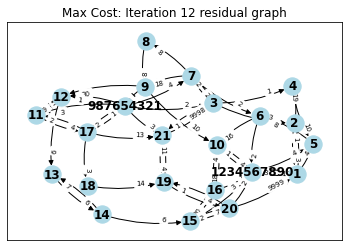

Iteration 13 augmenting path
[987654321]


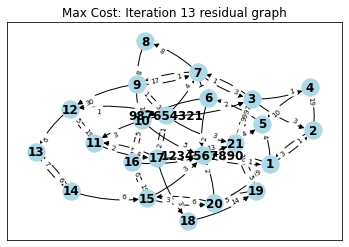

Min Cost
Iteration 1 negative cycle


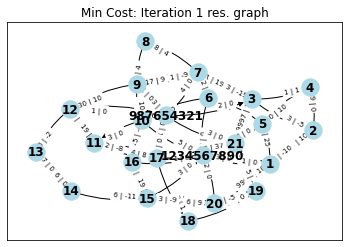

Iteration 1 negative cycle


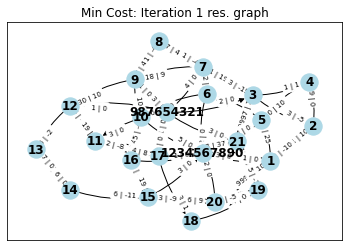

{(1, 5): 0, (1, 2): 3, (2, 4): 0, (2, 3): 3, (3, 7): 3, (3, 4): 0, (4, 5): 0, (5, 6): 0, (6, 10): 0, (6, 7): 2, (7, 9): 0, (7, 8): 1, (8, 9): 1, (9, 12): 0, (9, 10): 0, (10, 16): 5, (11, 17): 2, (12, 11): 5, (13, 12): 6, (14, 13): 6, (15, 20): 3, (15, 14): 6, (16, 15): 6, (17, 21): 0, (17, 18): 0, (18, 19): 0, (19, 21): 5, (20, 1): 0, (20, 19): 5, (21, 3): 2}
Min costs: 557


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  9 11:21:20 2021

@author: Bernhard
"""

import networkx as nx
import math
import matplotlib.pyplot as plt
import heapq
import scipy


def bellman_moore_ford(graph, source, weight='weight'):
    # initialize
    distance = {v: math.inf for v in graph}
    predecessor = {v: None for v in graph}

    # shortest paths from source to all other nodes
    distance[source] = 0
    for _ in range(len(graph) - 1):
        change = False  # abort when converged
        for (u, v, w) in graph.edges.data(weight, default=math.inf):
            d = distance[u] + w
            if d < distance[v]:
                distance[v], predecessor[v] = d, u
                change = True
        if not change: break

    return distance, predecessor


# the returned cycle is in the opposite direction, edges are between higher and lower index, not vice versa
def find_negative_cycle(graph, dist, pred, weight='weight'):
    for (u, v, w) in graph.edges.data(weight, default=math.inf):
        if dist[u] + w < dist[v]:
            # there is a negative cycle, note this cycle need not start at u or v
            seen = {u: 0}
            cycle = [u]
            x = pred[u]
            # trace back to find a reocurrence among the predecessors
            while not x in seen:
                seen[x] = len(cycle)
                cycle.append(x)
                x = pred[x]
            # add the cycle start to the end of the list
            cycle.append(x)
            return cycle[seen[x]:]
    return []


# This is an example of a graph with a sequence 1 -> 2 -> 3 -> 4 -> 5 and a negative cycle in 3 -> 7 -> 6 -> 3
"""
graph = nx.DiGraph()
graph.add_weighted_edges_from([(7, 6, -1), (6, 3, -1), (1, 2, 1), (2, 3, 2), (3, 4, 2), (4, 5, 1), (3, 7, 1)])
pos = {1: (0, 0), 2: (1, 0), 3: (2, 0), 4: (3, 0), 5: (4, 0), 6: (1, 1), 7: (3, 1)}
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph,'weight'))
plt.show()
(dist, pred) = bellman_moore_ford(graph, 1, 'weight')
print(find_negative_cycle(graph, dist, pred))
"""


# our Dijkstra modified to take into account number of edges only
# will be used to find augmenting paths in max_flow
def dijkstra_edgecount(G, start, end):
    visited = set()
    dist = {v: float("inf") for v in G}
    dist[start] = 0
    previous = {}
    unvisitedQueue = [(dist[v], v) for v in G]
    heapq.heapify(unvisitedQueue)
    while not end in visited:
        current = heapq.heappop(unvisitedQueue)[1]
        if current not in visited:
            visited.add(current)
            new_dist = dist[current] + 1
            for n in G[current]:
                if n in visited: continue
                if new_dist < dist[n]:
                    dist[n] = new_dist
                    previous[n] = current
                    heapq.heappush(unvisitedQueue, (new_dist, n))
    return previous


# the returned path is in opposite direction, edges are between higher and lower index, not vice versa
def get_path(prev, target):
    path = [target]
    c = target
    while c in prev:
        c = prev[c]
        path.append(c)
    return path


# an oriented graph is assumed (no forward and backward edges in graph at the same time)
def max_flow(graph, source, sink, capacity='capacity'):
    print("Max Flow")
    flow = {(u, v): 0 for (u, v) in graph.edges}
    residual = graph.copy()
    iterations = 1
    while True:
        # find augmenting path (any path is an augmenting path since we remove edges with 0 capacity)
        pred = dijkstra_edgecount(residual, source, sink)
        path = get_path(pred, sink)
        print("Iteration", iterations, "augmenting path")
        print(path)
        print_with_capacity(residual, f"Max Cost: Iteration {iterations} residual graph")
        iterations += 1
        if (len(path) == 1):  # no more augmenting path
            return flow
        # obtain minimum capacity along the path, note edges are <- in the path, not ->
        mincap = min([residual[path[i]][path[i - 1]][capacity] for i in range(1, len(path))])
        for i in range(1, len(path)):
            u, v = path[i], path[i - 1]
            if (u, v) in flow:  # forward edge, reduce capacity on edge (or remove it) and increase flow
                if residual[u][v][capacity] == mincap:
                    residual.remove_edge(u, v)
                else:
                    residual[u][v][capacity] -= mincap
                if flow[(u, v)] == 0:
                    residual.add_edge(v, u)
                    residual[v][u][capacity] = mincap
                else:
                    residual[v][u][capacity] += mincap
                flow[(u, v)] += mincap
            else:  # backward edge, increase capacity on edge (or add it) and decrease flow
                if u in residual[v]:
                    residual[v][u][capacity] += mincap
                else:
                    residual.add_edge(v, u)
                    residual[v][u][capacity] = mincap
                if flow[(v, u)] == mincap:
                    residual.remove_edge(u, v)
                else:
                    residual[u][v][capacity] -= mincap
                flow[(v, u)] -= mincap


# takes a graph and a flow and creates the residual graph
# will be used in max_flow_min_cost
def get_residual(graph, flow, capacity='capacity', cost='cost'):
    residual = graph.copy()
    for e in graph.edges:
        (u, v) = e
        if flow[e] > 0:  # for all flows a backward edge is introduced
            residual.add_edge(v, u)
            residual[v][u][capacity] = flow[e]
            residual[v][u][cost] = -residual[u][v][cost]
            residual[u][v][capacity] -= flow[e]
            if residual[u][v][capacity] == 0:
                residual.remove_edge(u, v)
    return residual


# assumes a graph with suppliers (positive b), demands (negative b), and transshipment nodes (0 b)
def max_flow_min_cost(graph, b, capacity='capacity', cost='cost'):
    # turn graph into a network by introducing artificial SRC and TGT node
    network = graph.copy()
    SRC = 1234567890
    TGT = 987654321
    for n in graph:
        if b[n] > 0:  # connect SRC to supplier
            network.add_edge(SRC, n, capacity=b[n], cost=0)
        elif b[n] < 0:  # connect TGT to demand
            network.add_edge(n, TGT, capacity=-b[n], cost=0)
    # calculate max_flow on that network
    flow = max_flow(network, SRC, TGT, capacity)
    # get the residual graph
    residual = get_residual(network, flow, capacity, cost)
    print("Min Cost")
    iterations = 1
    while True:
        # find augmenting cycle (among costs!), note we use TGT as source,
        # because that should be connected to every node due to backward flow edges
        (dist, pred) = bellman_moore_ford(residual, TGT, weight=cost)
        cycle = find_negative_cycle(residual, dist, pred, weight=cost)
        print("Iteration", iterations, "negative cycle")
        print_with_capacity_and_cost(residual, f"Min Cost: Iteration {iterations} res. graph")
        if len(cycle) == 0:  # no more cycle
            # remove SRC and TGT from flow before returning
            result = {}
            for e in graph.edges:
                if e in flow:
                    result[e] = flow[e]
            return result
        # find minimum capacity along the cycle
        mincap = min([residual[cycle[i]][cycle[i - 1]][capacity] for i in range(1, len(cycle))])
        for i in range(1, len(cycle)):
            u, v = cycle[i], cycle[i - 1]
            if (u, v) in flow:  # forward edge, reduce capacity on edge (or remove it) and increase flow
                if residual[u][v][capacity] == mincap:
                    residual.remove_edge(u, v)
                else:
                    residual[u][v][capacity] -= mincap
                if flow[(u, v)] == 0:
                    residual.add_edge(v, u, capacity=mincap, cost=-residual[u][v][cost])
                else:
                    residual[v][u][capacity] += mincap
                flow[(u, v)] += mincap
            else:  # backward edge, increase capacity on edge (or add it) and decrease flow
                if u in residual[v]:
                    residual[v][u][capacity] += mincap
                else:
                    residual.add_edge(v, u, capacity=mincap, cost=-residual[u][v][cost])
                if flow[(v, u)] == mincap:
                    residual.remove_edge(u, v)
                else:
                    residual[u][v][capacity] -= mincap
                flow[(v, u)] -= mincap


def print_with_capacity(graph: nx.Graph, name=None):
    pos = nx.kamada_kawai_layout(graph)
    nx.draw_networkx(graph, pos, node_color="lightblue", font_weight="bold", connectionstyle='arc3, rad = 0.12')
    edge_labels = dict([((u, v,), f"{d['capacity']}")
                        for u, v, d in graph.edges(data=True)])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)
    plt.title(name)
    plt.show(name)


def print_with_capacity_and_cost(graph: nx.Graph, name=None):
    pos = nx.kamada_kawai_layout(graph)
    nx.draw_networkx(graph, pos, node_color="lightblue", font_weight="bold", connectionstyle='arc3, rad = 0.12')
    edge_labels = dict([((u, v,), f"{d['capacity']} | {d['cost']}")
                        for u, v, d in graph.edges(data=True)])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)
    plt.title(name)
    plt.show(name)


def costs(graph: nx.DiGraph, flow):
    cost = 0
    for (u, v) in flow:
        cost += graph[u][v]['cost'] * flow[(u, v)]
    return cost

digraph = nx.DiGraph()

digraph.add_node(1, b=4, subset=1)
digraph.add_node(2, b=0, subset=2)
digraph.add_node(3, b=-2, subset=3)
digraph.add_node(4, b=0, subset=2)
digraph.add_node(5, b=4, subset=1)

digraph.add_node(6, b=2, subset=1)
digraph.add_node(7, b=-4, subset=3)
digraph.add_node(8, b=0, subset=2)
digraph.add_node(9, b=-4, subset=3)
digraph.add_node(10, b=6, subset=1)

digraph.add_node(11, b=-3, subset=3)
digraph.add_node(12, b=-1, subset=3)
digraph.add_node(13, b=0, subset=2)
digraph.add_node(14, b=0, subset=2)
digraph.add_node(15, b=3, subset=1)
digraph.add_node(16, b=1, subset=1)

digraph.add_node(17, b=-3, subset=3)
digraph.add_node(18, b=0, subset=2)
digraph.add_node(19, b=0, subset=2)
digraph.add_node(20, b=2, subset=1)
digraph.add_node(21, b=-3, subset=3)

digraph.add_edge(20, 1, capacity=9999, cost=100)
digraph.add_edge(21, 3, capacity=9999, cost=100)

#lower
digraph.add_edge(1, 5, capacity=4, cost=25)
digraph.add_edge(5, 6, capacity=8, cost=7)
digraph.add_edge(6, 10, capacity=16, cost=100)
digraph.add_edge(10, 16, capacity=22, cost=4)
digraph.add_edge(16, 15, capacity=25, cost=6)
digraph.add_edge(15, 20, capacity=9, cost=9)
#middle
digraph.add_edge(2, 4, capacity=19, cost=0)
digraph.add_edge(14, 13, capacity=13, cost=0)
digraph.add_edge(18, 19, capacity=14, cost=0)
#upper
digraph.add_edge(3, 7, capacity=4, cost=19)
digraph.add_edge(7, 9, capacity=18, cost=9)
digraph.add_edge(9, 12, capacity=30, cost=10)
digraph.add_edge(12, 11, capacity=24, cost=4)
digraph.add_edge(11, 17, capacity=6, cost=8)
digraph.add_edge(17, 21, capacity=13, cost=37)

#oblique
digraph.add_edge(1, 2, capacity=4, cost=10)
digraph.add_edge(2, 3, capacity=3, cost=5)
digraph.add_edge(3, 4, capacity=1, cost=1)
digraph.add_edge(4, 5, capacity=10, cost=10)

digraph.add_edge(6, 7, capacity=2, cost=10)
digraph.add_edge(7, 8, capacity=8, cost=4)
digraph.add_edge(8, 9, capacity=8, cost=4)
digraph.add_edge(9, 10, capacity=10, cost=0)

digraph.add_edge(13, 12, capacity=6, cost=2)
digraph.add_edge(15, 14, capacity=6, cost=11)

digraph.add_edge(20, 19, capacity=5, cost=5)
digraph.add_edge(17, 18, capacity=3, cost=1)

digraph.add_edge(19, 21, capacity=15, cost=1)

pos = nx.multipartite_layout(digraph)  # keep in mind that some edges are drawn overlapped here

b = {1: 4, 2: 0, 3: -2, 4: 0, 5: 4, 6: 2, 7: -4, 8: 0, 9: -4, 10: 5, 11: -3,
12: -1, 13: 0, 14: 0, 15: 3, 16: 1, 17: -3, 18: 0, 19: 0, 20: 2, 21: -3}

flow = max_flow_min_cost(digraph, b, 'capacity', 'cost')
print(flow)
print("Min costs:", costs(digraph, flow))